In [1]:
import numpy as np                   
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import os
import rasterio
import re
from affine import Affine

sns.set_style("darkgrid")
sns.set_context("paper")
%matplotlib inline
plt.rcParams["font.sans-serif"]='SimHei'   #解决中文乱码问题
plt.rcParams['axes.unicode_minus']=False   #解决负号无法显示的问题  
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',8)             # 最多显示8列
pd.set_option('display.max_rows',15)                # 最多显示8行

## 数据提取测试，可以跳过

In [64]:
def read_tfw(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        tfw_params = [float(line.strip()) for line in lines]
        
        if len(tfw_params) != 6:
            raise ValueError("Invalid .tfw file: should contain exactly six parameters.")
        
        return {
            'pixel_size_x': tfw_params[0],  # 水平像素大小
            'row_rotation': tfw_params[1],  # 行旋转
            'col_rotation': tfw_params[2],  # 列旋转
            'pixel_size_y': tfw_params[3],  # 垂直像素大小
            'upper_left_x': tfw_params[4],  # 左上角 X 坐标
            'upper_left_y': tfw_params[5]}   # 左上角 Y 坐标}

tfw_file_path = '1900.tfw'
tfw_data = read_tfw(tfw_file_path)
print("TWF Data:", tfw_data)

TWF Data: {'pixel_size_x': 0.5, 'row_rotation': 0.0, 'col_rotation': 0.0, 'pixel_size_y': -0.5, 'upper_left_x': 72.47499999, 'upper_left_y': 55.325}


In [65]:
import rasterio

# 读取 GeoTIFF 文件
tif_file_path = '1900.tif'
with rasterio.open(tif_file_path) as src:
    # 读取图像数据的第一个波段
    band1 = src.read(1)
    # 获取原始图像的仿射变换矩阵和CRS
    original_transform = src.transform
    crs = src.crs

print(f"GeoTIFF Width: {src.width}, Height: {src.height}")
print(f"CRS (Coordinate Reference System): {crs}")
print(f"Original Affine Transform: {original_transform}")

GeoTIFF Width: 127, Height: 78
CRS (Coordinate Reference System): EPSG:4326
Original Affine Transform: | 0.50, 0.00, 72.22|
| 0.00,-0.50, 55.58|
| 0.00, 0.00, 1.00|


In [66]:
from affine import Affine

# 使用 .tfw 文件中的数据创建仿射变换矩阵
tfw_transform = Affine(
    tfw_data['pixel_size_x'],
    tfw_data['row_rotation'],
    tfw_data['upper_left_x'],
    tfw_data['col_rotation'],
    tfw_data['pixel_size_y'],
    tfw_data['upper_left_y'])

print("New Affine Transform from .tfw data:", tfw_transform)

New Affine Transform from .tfw data: | 0.50, 0.00, 72.47|
| 0.00,-0.50, 55.33|
| 0.00, 0.00, 1.00|


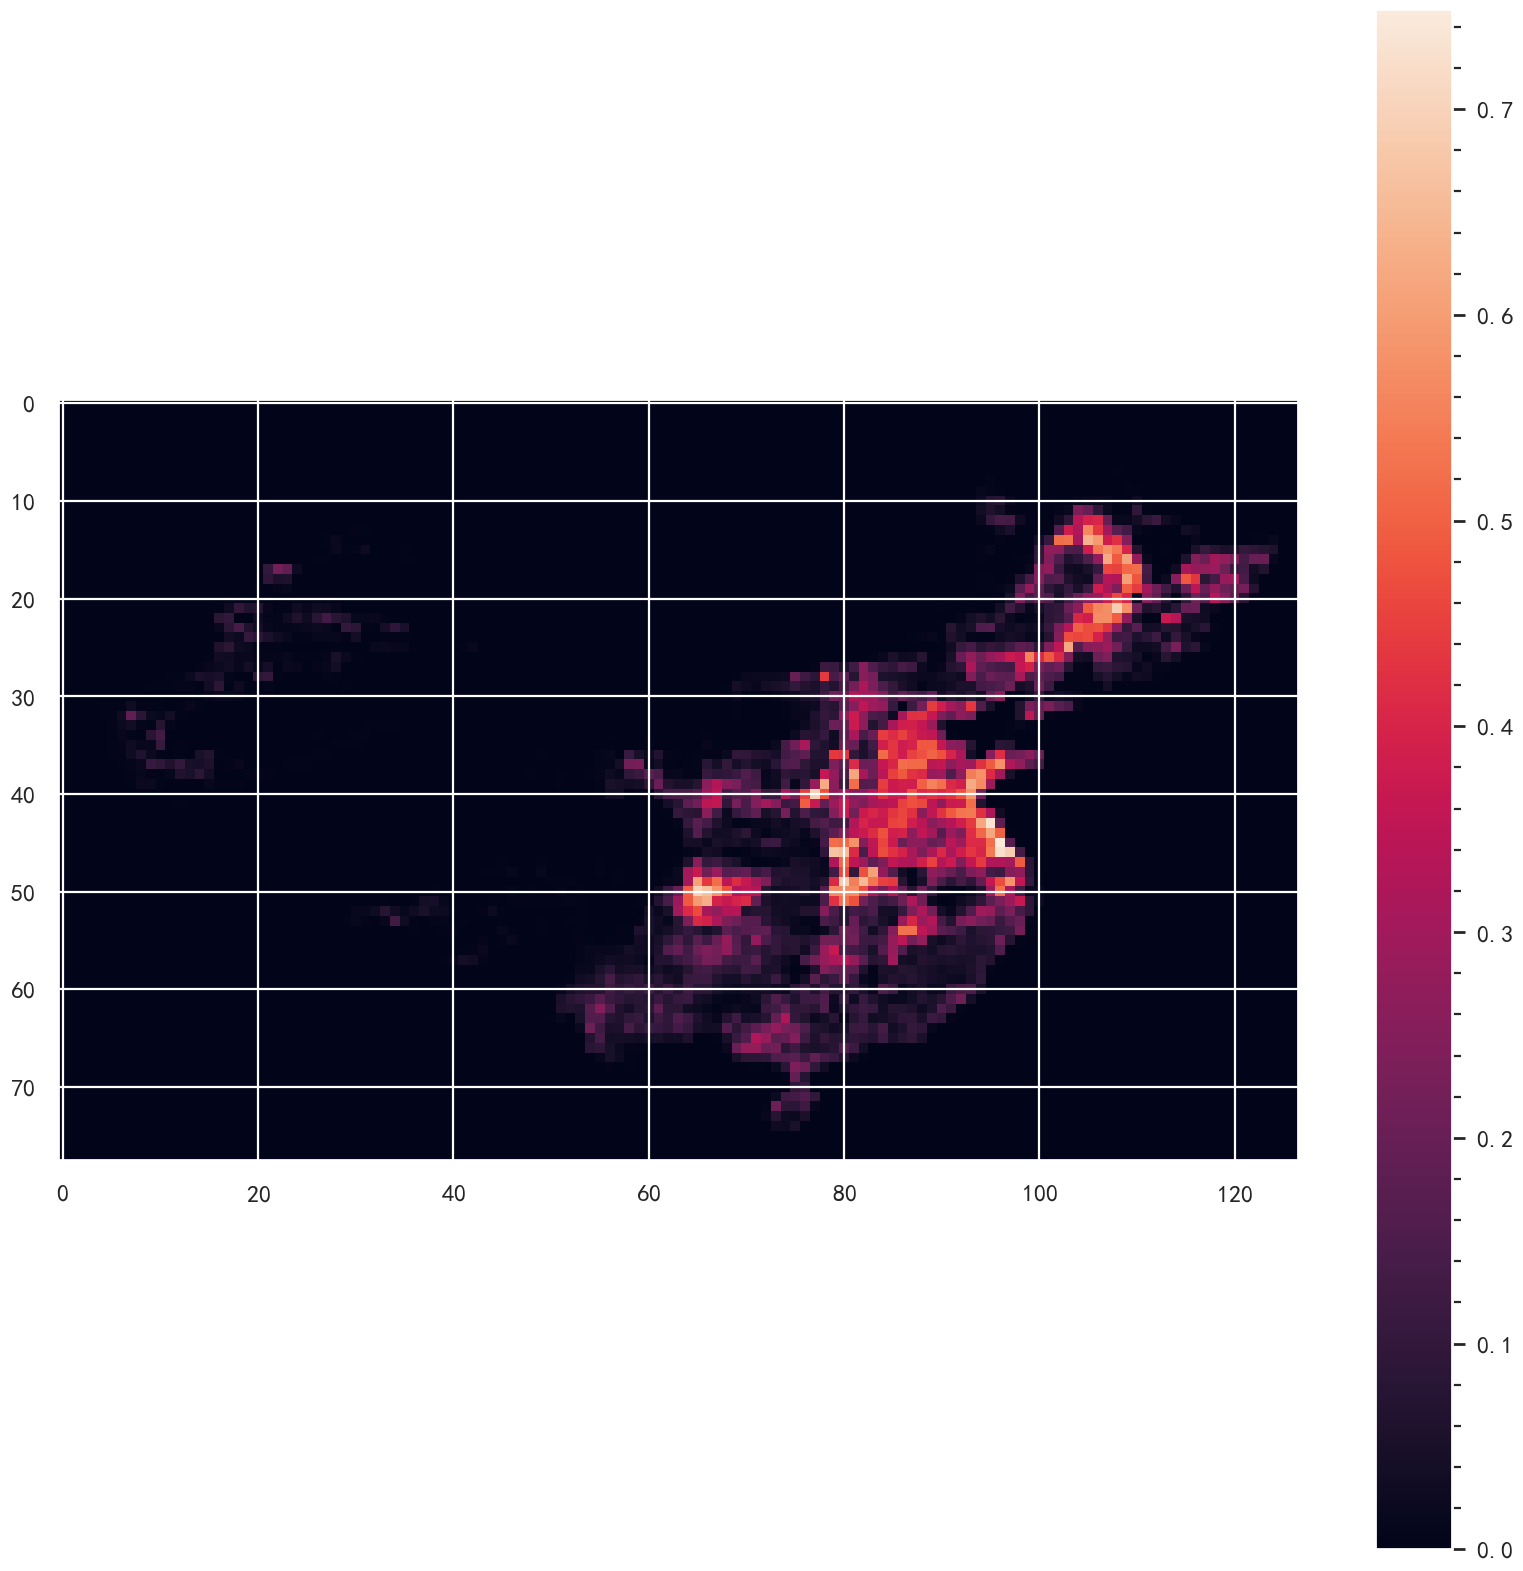

In [67]:
plt.figure(figsize=(10,10),dpi=200)
plt.imshow(band1)
plt.colorbar()
plt.savefig('C:/Users/c/Desktop/croland1900.png',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

In [68]:
min_value = np.min(band1)
max_value = np.max(band1)
mean_value = np.mean(band1)
median_value = np.median(band1)
std_dev = np.std(band1)

print(f"Min Value: {min_value}")
print(f"Max Value: {max_value}")
print(f"Mean Value: {mean_value}")
print(f"Median Value: {median_value}")
print(f"Standard Deviation: {std_dev}")

Min Value: 0.0
Max Value: 0.748467743396759
Mean Value: 0.032075751572847366
Median Value: 0.0
Standard Deviation: 0.09252863377332687


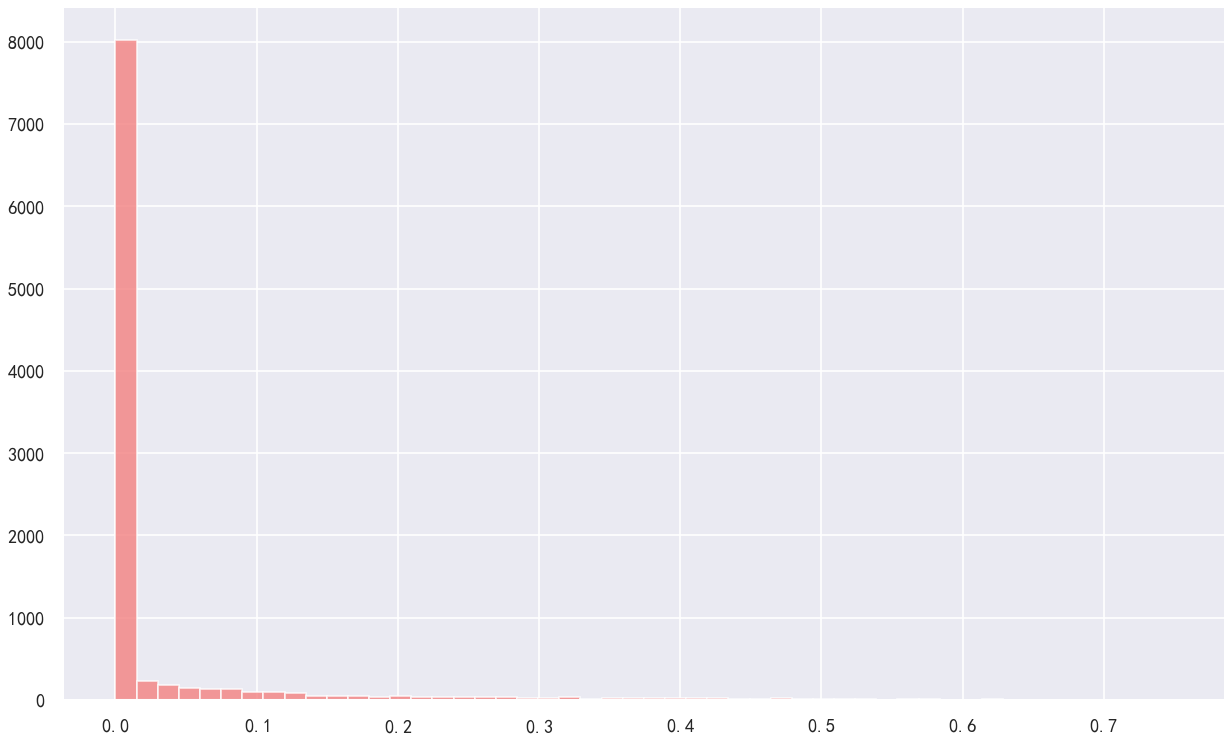

In [69]:
plt.figure(figsize=(10,6),dpi=150)
plt.hist(band1.flatten(),bins=50,color="#F38181",alpha=0.8)
plt.savefig('C:/Users/c/Desktop/croland统计1.tif',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

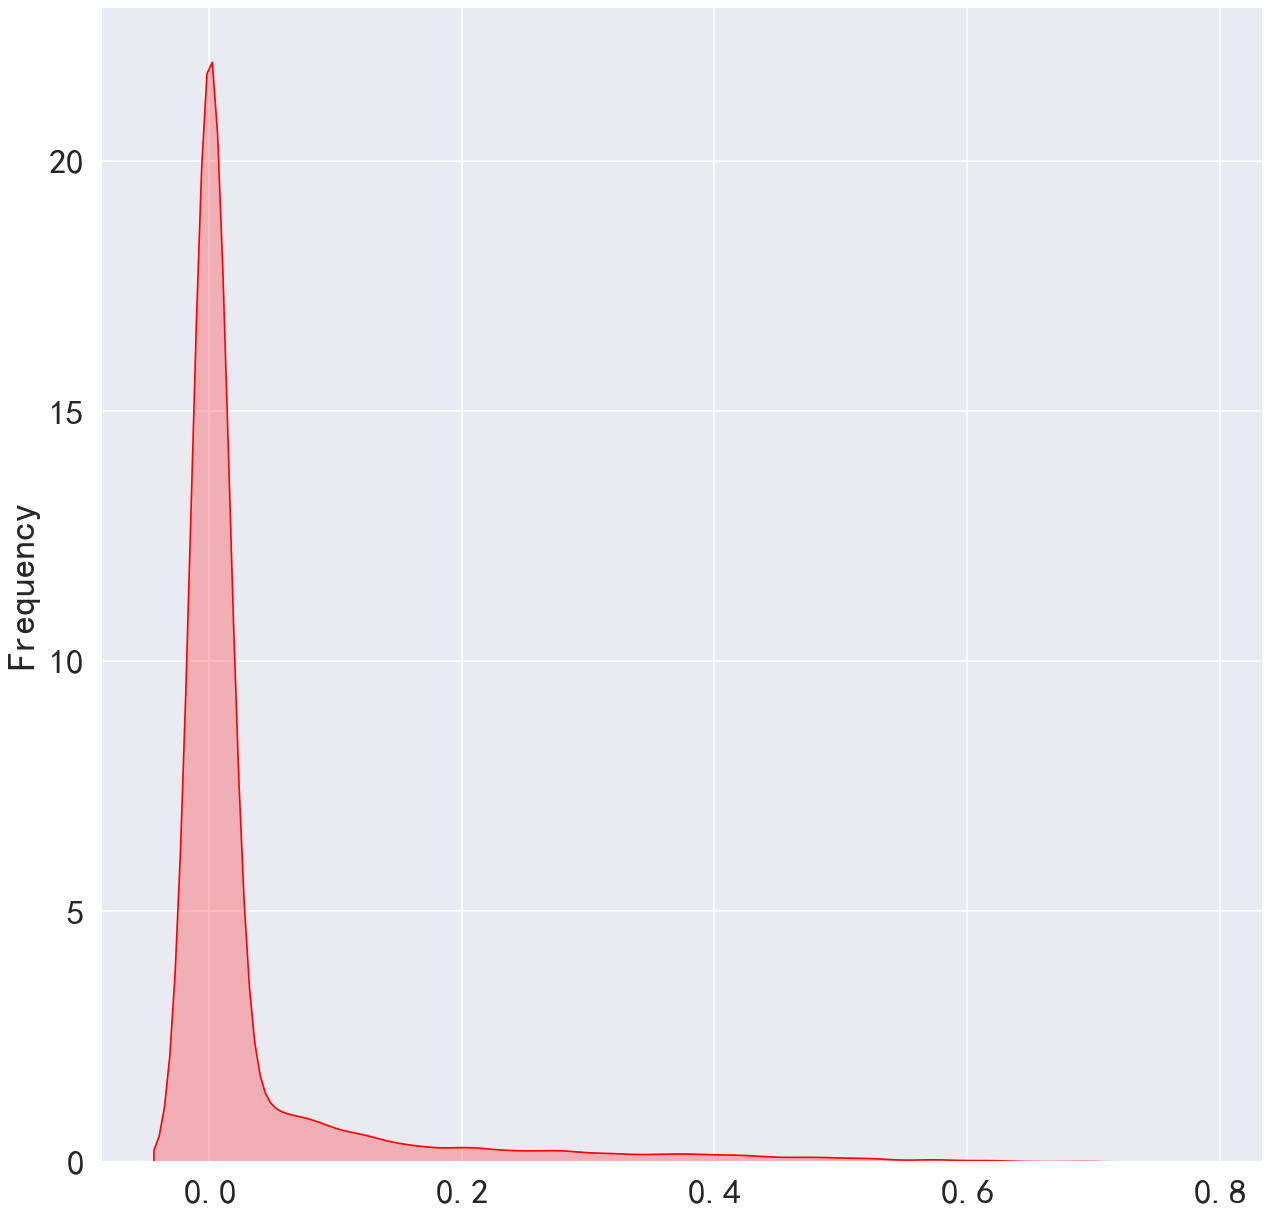

In [70]:
plt.figure(figsize=(10,10),dpi=150)
sns.kdeplot(band1.flatten(),color="Red",shade=True)
plt.ylabel("Frequency",fontsize=18)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('C:/Users/c/Desktop/croland统计2.tif',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')

## 第一问土地类型数据

### cropland

In [76]:
import os
import rasterio
import re

def read_tif(file_path):
   
    with rasterio.open(file_path) as src:
        band_data = src.read(1)
        return band_data

def extract_year_from_filename(file_name):
   
    match = re.search(r'(\d{4})',file_name)
    if match:
        return int(match.group(1))
    raise ValueError(f"Could not extract year from file name: {file_name}")

def process_folder(folder_path):
    
    year_stats = []
    
    # 遍历文件夹中的所有文件
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):
            # 提取年份
            year = extract_year_from_filename(file_name)
            if 1900 <= year <= 2019:  
                tif_path = os.path.join(folder_path, file_name)
                
                # 读取 .tif 文件数据
                tif_data = read_tif(tif_path)
                
                # 计算统计信息
                mean_value = np.mean(tif_data)
                max_value = np.max(tif_data)
                min_value = np.min(tif_data)
                std_dev = np.std(tif_data)
                
                # 存储年份和统计信息
                year_stats.append({
                    'Year': year,
                    'Mean': mean_value,
                    'Max': max_value,
                    'Min': min_value,
                    'StdDev': std_dev
                })
    
    return pd.DataFrame(year_stats).sort_values(by='Year')


folder_path = 'C:/Users/c/Desktop/python数据分析/研赛/crop/'  
yearly_stats_df1 = process_folder(folder_path)

In [63]:
yearly_stats_df1

,Year,Mean,Max,Min,StdDev
0,1900,0.032076,0.748468,0.0,0.092529
1,1901,0.032269,0.748393,0.0,0.093046
2,1902,0.032461,0.748307,0.0,0.093567
3,1903,0.032654,0.748223,0.0,0.094092
4,1904,0.032848,0.748133,0.0,0.094628
...,...,...,...,...,...
115,2015,0.060043,0.932604,0.0,0.155151
116,2016,0.060334,0.932177,0.0,0.155872
117,2017,0.060690,0.932607,0.0,0.156677
118,2018,0.060750,0.932818,0.0,0.156737


In [65]:
yearly_stats_df1.to_excel("C:/Users/c/Desktop/cropland.xlsx")

### forest

In [66]:
folder_path2 = 'C:/Users/c/Desktop/python数据分析/研赛/forest/'  
yearly_stats_df2 = process_folder(folder_path2)
yearly_stats_df2

,Year,Mean,Max,Min,StdDev
0,1900,0.065298,0.976532,0.0,0.173199
1,1901,0.064975,0.975944,0.0,0.172575
2,1902,0.064652,0.975355,0.0,0.171953
3,1903,0.064329,0.974766,0.0,0.171333
4,1904,0.064006,0.974176,0.0,0.170713
...,...,...,...,...,...
115,2015,0.087482,0.992401,0.0,0.191958
116,2016,0.088579,0.992722,0.0,0.193744
117,2017,0.089715,0.993043,0.0,0.195616
118,2018,0.090770,0.993363,0.0,0.197374


In [67]:
yearly_stats_df2.to_excel("C:/Users/c/Desktop/forest.xlsx")

### grass

In [68]:
folder_path3 = 'C:/Users/c/Desktop/python数据分析/研赛/grass/'  
yearly_stats_df3 = process_folder(folder_path3)
yearly_stats_df3

,Year,Mean,Max,Min,StdDev
0,1900,0.238405,1.0,0.0,0.338749
1,1901,0.238469,1.0,0.0,0.338732
2,1902,0.238532,1.0,0.0,0.338716
3,1903,0.238595,1.0,0.0,0.338702
4,1904,0.238657,1.0,0.0,0.338690
...,...,...,...,...,...
115,2015,0.204338,1.0,0.0,0.314883
116,2016,0.203344,1.0,0.0,0.314395
117,2017,0.202275,1.0,0.0,0.313888
118,2018,0.201508,1.0,0.0,0.313476


In [69]:
yearly_stats_df3.to_excel("C:/Users/c/Desktop/grass.xlsx")

### shrub

In [70]:
folder_path4 = 'C:/Users/c/Desktop/python数据分析/研赛/shrub/'  
yearly_stats_df4 = process_folder(folder_path4)
yearly_stats_df4

,Year,Mean,Max,Min,StdDev
0,1900,0.075539,1.0,0.0,0.159452
1,1901,0.075606,1.0,0.0,0.159501
2,1902,0.075673,1.0,0.0,0.159551
3,1903,0.075740,1.0,0.0,0.159601
4,1904,0.075807,1.0,0.0,0.159651
...,...,...,...,...,...
115,2015,0.063884,1.0,0.0,0.146994
116,2016,0.063505,1.0,0.0,0.146759
117,2017,0.063101,1.0,0.0,0.146516
118,2018,0.062769,1.0,0.0,0.146310


In [71]:
yearly_stats_df4.to_excel("C:/Users/c/Desktop/shrub.xlsx")

### wet

In [72]:
folder_path5 = 'C:/Users/c/Desktop/python数据分析/研赛/wet/'  
yearly_stats_df5 = process_folder(folder_path5)
yearly_stats_df5

,Year,Mean,Max,Min,StdDev
0,1900,0.011052,0.734907,0.0,0.040483
1,1901,0.011052,0.734907,0.0,0.040483
2,1902,0.011052,0.734907,0.0,0.040483
3,1903,0.011052,0.734907,0.0,0.040483
4,1904,0.011052,0.734907,0.0,0.040483
...,...,...,...,...,...
115,2015,0.006625,0.496855,0.0,0.028715
116,2016,0.006608,0.496855,0.0,0.028653
117,2017,0.006591,0.496855,0.0,0.028596
118,2018,0.006574,0.496855,0.0,0.028542


In [73]:
yearly_stats_df5.to_excel("C:/Users/c/Desktop/wet.xlsx")

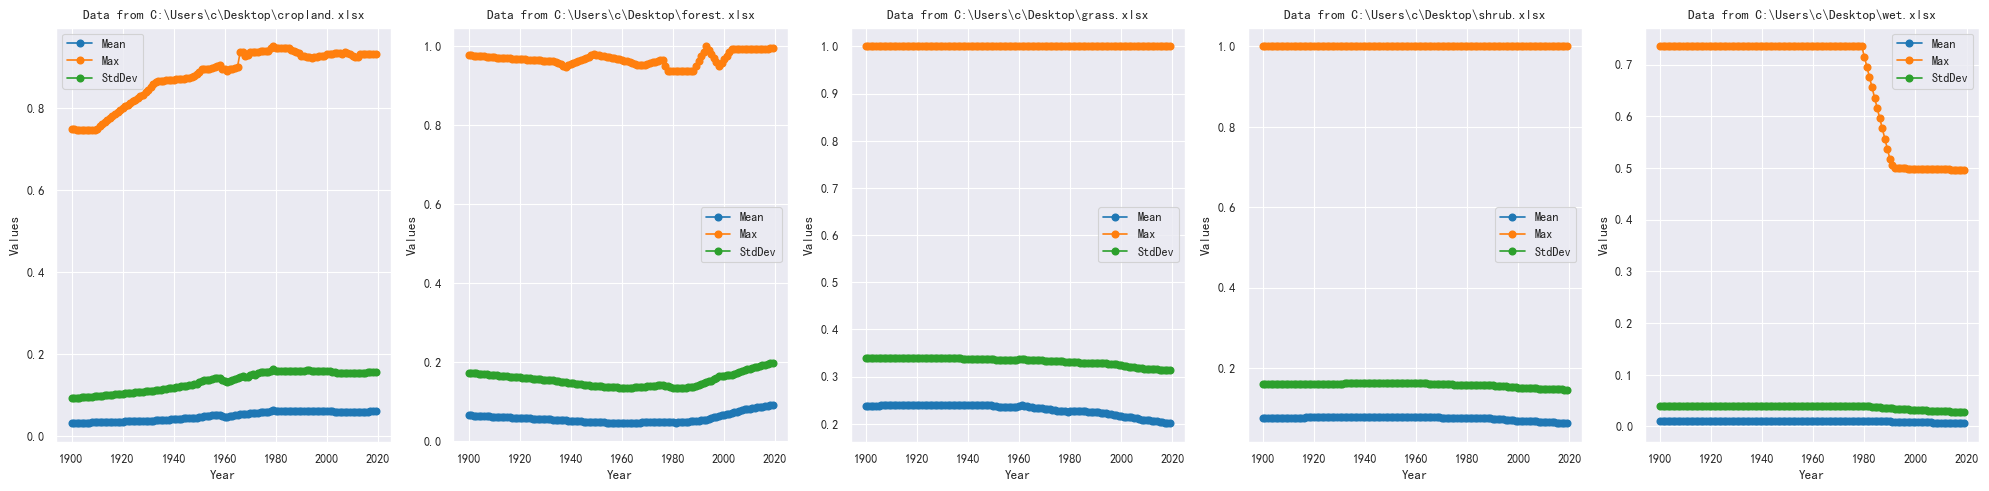

In [74]:
# 创建一个函数来绘制单个文件的数据
def plot_data_from_excel(file_path, ax):
    # 读取Excel文件
    df = pd.read_excel(file_path)
    
    # 提取各列
    years = df['Year']
    mean_values = df['Mean']
    max_values = df['Max']
    min_values = df['Min']
    stddev_values = df['StdDev']
    
    # 绘制每列数据
    ax.plot(years, mean_values, label='Mean', marker='o')
    ax.plot(years, max_values, label='Max', marker='o')
    ax.plot(years, stddev_values, label='StdDev', marker='o')
    
    # 添加图例、标题和坐标标签
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Values')
    ax.set_title(f'Data from {file_path.split("/")[-1]}')

# 文件列表（修改为你自己的文件路径）
file_list = [
    r'C:\Users\c\Desktop\cropland.xlsx',
    r'C:\Users\c\Desktop\forest.xlsx',
    r'C:\Users\c\Desktop\grass.xlsx',
    r'C:\Users\c\Desktop\shrub.xlsx',
    r'C:\Users\c\Desktop\wet.xlsx'
]

# 创建组图
fig, axs = plt.subplots(1, 5, figsize=(20,5))

# 对每个文件生成一个子图
for i, file_path in enumerate(file_list):
    plot_data_from_excel(file_path, axs[i])

# 调整子图布局
plt.tight_layout()
plt.show()

## 第二问

### 高程数据

In [2]:
with rasterio.open(r'chdem_105.tif') as df1:
    value1 = df1.read(1) 
    value1 = value1.astype(np.float32)
    value1[value1<-500] = np.nan      # 设置的临界值
    bounds1 = df1.bounds
    left1,bottom1,right1,top1 = bounds1
    transform1 = df1.transform
    xvalue1 = df1.width
    yvalue1 = df1.height
    
    xaltitude1 = np.linspace(left1,right1,xvalue1)
    yaltitude1 = np.linspace(bottom1,top1,yvalue1)
    Xaltitude1, Yaltitude1 = np.meshgrid(xaltitude1, yaltitude1)   # 网格化
    
df1_output = pd.DataFrame(value1)
df1_output

,0,1,2,3,...,7058,7059,7060,7061
0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5014,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5015,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5016,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5017,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN


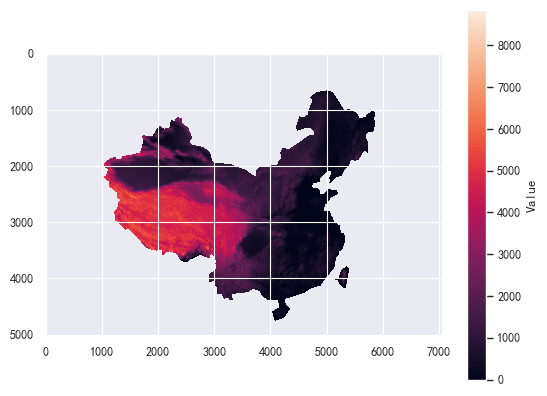

In [113]:
plt.imshow(df1_output)
plt.colorbar(label='Value')
plt.savefig('C:/Users/c/Desktop/高程.jpg',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')

### 坡向数据

In [3]:
with rasterio.open(r'chdem_Aspect.tif') as df2:
    value2 = df2.read(1)  
    value2[value2<-500] = np.nan      
    bounds2 = df2.bounds
    left2,bottom2,right2,top2 = bounds2
    transform2 = df2.transform
    xvalue2 = df2.width
    yvalue2 = df2.height
    
    xaltitude2 = np.linspace(left2,right2,xvalue2)
    yaltitude2 = np.linspace(bottom2,top2,yvalue2)
    Xaltitude2, Yaltitude2 = np.meshgrid(xaltitude2, yaltitude2)
# df2_output = pd.DataFrame(value2,index=yaltitude2,columns=xaltitude2)
df2_output = pd.DataFrame(value2)
df2_output

,0,1,2,3,...,7058,7059,7060,7061
0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5014,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5015,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5016,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5017,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN


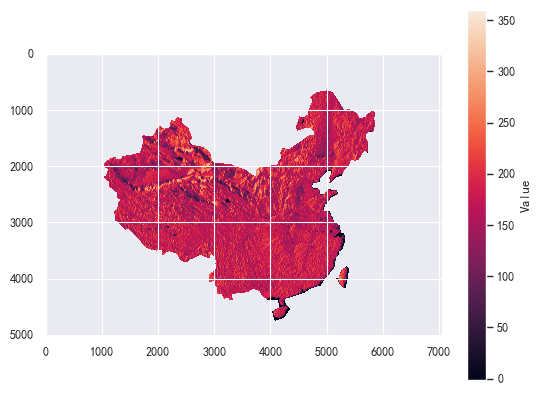

In [115]:
plt.imshow(df2_output)
plt.colorbar(label='Value')
plt.savefig('C:/Users/c/Desktop/坡向.jpg',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')

### 坡度数据

In [4]:
with rasterio.open(r'chdem_Slope.tif') as df3:
    value3 = df3.read(1)  
    value3[value3<-5000] = np.nan      
    bounds3 = df3.bounds
    left3,bottom3,right3,top3 = bounds3
    transform3 = df3.transform
    xvalue3 = df3.width
    yvalue3 = df3.height
    
    xaltitude3 = np.linspace(left3,right3,xvalue3)
    yaltitude3 = np.linspace(bottom3,top3,yvalue3)
    Xaltitude3, Yaltitude3 = np.meshgrid(xaltitude3, yaltitude3)
df3_output = pd.DataFrame(value3)
df3_output

,0,1,2,3,...,7058,7059,7060,7061
0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5014,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5015,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5016,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
5017,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN


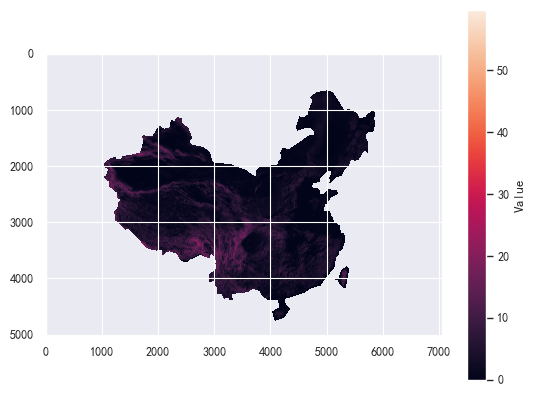

In [118]:
plt.imshow(df3_output)
plt.colorbar(label='Value')
plt.savefig('C:/Users/c/Desktop/坡度.jpg',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')

### 土地利用数据

In [59]:
import os
import rasterio
import re
import pandas as pd
import numpy as np

def read_tif(file_path):  
    with rasterio.open(file_path) as src:
        band_data = src.read(1).astype(np.float32) 
        return band_data, src.bounds, src.transform, src.width, src.height

def extract_year_from_filename(file_name):
    match = re.search(r'(\d{4})', file_name)
    if match:
        return int(match.group(1))
    raise ValueError(f"Could not extract year from file name: {file_name}")

def process_folder(folder_path):
    data_dict = {}
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):
            year = extract_year_from_filename(file_name)
            if 1961 <= year <= 2018:
                tif_path = os.path.join(folder_path, file_name)
                
                value, bounds, transform, xvalue, yvalue = read_tif(tif_path)
                left, bottom, right, top = bounds
                xaltitude = np.linspace(left, right, xvalue)
                yaltitude = np.linspace(bottom, top, yvalue)
                #df_output = pd.DataFrame(value, index=yaltitude, columns=xaltitude)
                df_output = pd.DataFrame(value)
                data_dict[year] = df_output
    
    return data_dict

def save_to_excel(data_dict, output_path):
    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        for year, df in data_dict.items():
            df.to_excel(writer, sheet_name=str(year), index=False)

folder_path = 'C:/Users/c/Desktop/python数据分析/研赛/crop/' 
all_year_data = process_folder(folder_path)

output_excel_path = 'C:/Users/c/Desktop/crop_data_1961_2018.xlsx'
save_to_excel(all_year_data, output_excel_path)
output_excel_path

'C:/Users/c/Desktop/crop_data_1961_2018.xlsx'

In [60]:
folder_path = 'C:/Users/c/Desktop/python数据分析/研赛/forest/' 
all_year_data = process_folder(folder_path)

output_excel_path = 'C:/Users/c/Desktop/forest_data_1961_2018.xlsx'
save_to_excel(all_year_data, output_excel_path)
output_excel_path

'C:/Users/c/Desktop/forest_data_1961_2018.xlsx'

In [61]:
folder_path = 'C:/Users/c/Desktop/python数据分析/研赛/grass/' 
all_year_data = process_folder(folder_path)

output_excel_path = 'C:/Users/c/Desktop/grass_data_1961_2018.xlsx'
save_to_excel(all_year_data, output_excel_path)
output_excel_path

'C:/Users/c/Desktop/grass_data_1961_2018.xlsx'

In [62]:
folder_path = 'C:/Users/c/Desktop/python数据分析/研赛/shrub/' 
all_year_data = process_folder(folder_path)

output_excel_path = 'C:/Users/c/Desktop/shrub_data_1961_2018.xlsx'
save_to_excel(all_year_data, output_excel_path)
output_excel_path

'C:/Users/c/Desktop/shrub_data_1961_2018.xlsx'

In [63]:
folder_path = 'C:/Users/c/Desktop/python数据分析/研赛/wet/' 
all_year_data = process_folder(folder_path)

output_excel_path = 'C:/Users/c/Desktop/wet_data_1961_2018.xlsx'
save_to_excel(all_year_data, output_excel_path)
output_excel_path

'C:/Users/c/Desktop/wet_data_1961_2018.xlsx'

## 关系求解

### 高程和土地类型

In [75]:
# 池化
def crop_to_divisible(matrix, target_shape):
    new_height = (matrix.shape[0] // target_shape[0]) * target_shape[0]
    new_width = (matrix.shape[1] // target_shape[1]) * target_shape[1]
    return matrix[:new_height, :new_width]

def downsample_matrix(matrix, target_shape):
    matrix_cropped = crop_to_divisible(matrix, target_shape)
    factor_x = matrix_cropped.shape[0] // target_shape[0]
    factor_y = matrix_cropped.shape[1] // target_shape[1]
    downsampled = matrix_cropped.reshape(target_shape[0], factor_x, target_shape[1], factor_y).mean(axis=(1, 3))
    return downsampled

df1_output=df1_output.fillna(0) 
large_matrix = df1_output.values  

excel_file_path = 'crop_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)

correlation_results1 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results1[sheet_name] = correlation
correlation_df1 = pd.DataFrame(list(correlation_results1.items()), columns=['Sheet Name', 'crop-高程'])
correlation_df1

,Sheet Name,crop-高程
0,1961,-0.012813
1,1962,-0.012977
2,1963,-0.013104
3,1964,-0.012275
4,1965,-0.012059
...,...,...
53,2014,-0.015721
54,2015,-0.015753
55,2016,-0.016059
56,2017,-0.016296


In [78]:
df1_output=df1_output.fillna(0) 
large_matrix = df1_output.values  

excel_file_path = 'forest_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results2 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results2[sheet_name] = correlation
correlation_df2 = pd.DataFrame(list(correlation_results2.items()),columns=['Sheet Name', 'forest-高程'])

excel_file_path = 'grass_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results3 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results3[sheet_name] = correlation
correlation_df3 = pd.DataFrame(list(correlation_results3.items()),columns=['Sheet Name', 'grass-高程'])

excel_file_path = 'shrub_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results4 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results4[sheet_name] = correlation
correlation_df4 = pd.DataFrame(list(correlation_results4.items()),columns=['Sheet Name', 'shrub-高程'])

excel_file_path = 'wet_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results5 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results5[sheet_name] = correlation
correlation_df5 = pd.DataFrame(list(correlation_results5.items()),columns=['Sheet Name', 'wet-高程'])

In [82]:
co1 = correlation_df1
co1['forest-高程']=correlation_df2['forest-高程']
co1['grass-高程']=correlation_df3['grass-高程']
co1['shrub-高程']=correlation_df4['shrub-高程']
co1['wet-高程']=correlation_df5['wet-高程']
co1

,Sheet Name,crop-高程,forest-高程,grass-高程,shrub-高程,wet-高程
0,1961,-0.012813,0.072926,0.558536,0.232679,0.131746
1,1962,-0.012977,0.070848,0.560321,0.233526,0.131746
2,1963,-0.013104,0.068586,0.562079,0.234454,0.131746
3,1964,-0.012275,0.066334,0.563671,0.235178,0.131746
4,1965,-0.012059,0.064086,0.564666,0.235865,0.131746
...,...,...,...,...,...,...
53,2014,-0.015721,0.153513,0.558980,0.216741,0.156966
54,2015,-0.015753,0.153939,0.559120,0.216365,0.155938
55,2016,-0.016059,0.154307,0.559386,0.216011,0.156437
56,2017,-0.016296,0.154585,0.559676,0.215651,0.156918


In [103]:
co1.to_excel("C:/Users/c/Desktop/高程和土地类型.xlsx")

### 坡向和土地类型

In [86]:
df2_output=df2_output.fillna(0) 
large_matrix = df2_output.values  

excel_file_path = 'crop_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results1 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results1[sheet_name] = correlation
correlation_df1 = pd.DataFrame(list(correlation_results1.items()), columns=['Sheet Name', 'crop-坡向'])

excel_file_path = 'forest_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results2 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results2[sheet_name] = correlation
correlation_df2 = pd.DataFrame(list(correlation_results2.items()),columns=['Sheet Name', 'forest-坡向'])

excel_file_path = 'grass_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results3 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results3[sheet_name] = correlation
correlation_df3 = pd.DataFrame(list(correlation_results3.items()),columns=['Sheet Name', 'grass-坡向'])

excel_file_path = 'shrub_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results4 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results4[sheet_name] = correlation
correlation_df4 = pd.DataFrame(list(correlation_results4.items()),columns=['Sheet Name', 'shrub-坡向'])

excel_file_path = 'wet_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results5 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results5[sheet_name] = correlation
correlation_df5 = pd.DataFrame(list(correlation_results5.items()),columns=['Sheet Name', 'wet-坡向'])

In [87]:
co2 = correlation_df1
co2['forest-坡向']=correlation_df2['forest-坡向']
co2['grass-坡向']=correlation_df3['grass-坡向']
co2['shrub-坡向']=correlation_df4['shrub-坡向']
co2['wet-坡向']=correlation_df5['wet-坡向']
co2

,Sheet Name,crop-坡向,forest-坡向,grass-坡向,shrub-坡向,wet-坡向
0,1961,0.321698,0.219142,0.578730,0.444223,0.133239
1,1962,0.323587,0.217088,0.577845,0.443479,0.133239
2,1963,0.325010,0.216223,0.576646,0.442442,0.133239
3,1964,0.328462,0.215356,0.575031,0.441060,0.133239
4,1965,0.329161,0.214472,0.574512,0.440574,0.133239
...,...,...,...,...,...,...
53,2014,0.327064,0.401661,0.512115,0.361045,0.105360
54,2015,0.327084,0.404355,0.510246,0.358649,0.103072
55,2016,0.326673,0.406907,0.508064,0.356143,0.103231
56,2017,0.326542,0.409392,0.505695,0.353410,0.103376


In [104]:
co2.to_excel("C:/Users/c/Desktop/坡向和土地类型.xlsx")

### 坡度和土地类型

In [88]:
df3_output=df3_output.fillna(0) 
large_matrix = df3_output.values  

excel_file_path = 'crop_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results1 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results1[sheet_name] = correlation
correlation_df1 = pd.DataFrame(list(correlation_results1.items()), columns=['Sheet Name', 'crop-坡度'])

excel_file_path = 'forest_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results2 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results2[sheet_name] = correlation
correlation_df2 = pd.DataFrame(list(correlation_results2.items()),columns=['Sheet Name', 'forest-坡度'])

excel_file_path = 'grass_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results3 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results3[sheet_name] = correlation
correlation_df3 = pd.DataFrame(list(correlation_results3.items()),columns=['Sheet Name', 'grass-坡度'])

excel_file_path = 'shrub_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results4 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results4[sheet_name] = correlation
correlation_df4 = pd.DataFrame(list(correlation_results4.items()),columns=['Sheet Name', 'shrub-坡度'])

excel_file_path = 'wet_data_1961_2018.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results5 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results5[sheet_name] = correlation
correlation_df5 = pd.DataFrame(list(correlation_results5.items()),columns=['Sheet Name', 'wet-坡度'])

In [89]:
co3 = correlation_df1
co3['forest-坡度']=correlation_df2['forest-坡度']
co3['grass-坡度']=correlation_df3['grass-坡度']
co3['shrub-坡度']=correlation_df4['shrub-坡度']
co3['wet-坡度']=correlation_df5['wet-坡度']
co3

,Sheet Name,crop-坡度,forest-坡度,grass-坡度,shrub-坡度,wet-坡度
0,1961,0.104028,0.259378,0.401777,0.305567,0.031124
1,1962,0.105091,0.255882,0.402743,0.306094,0.031124
2,1963,0.105679,0.253156,0.403354,0.306254,0.031124
3,1964,0.107826,0.250422,0.403742,0.305864,0.031124
4,1965,0.108374,0.247664,0.404277,0.306053,0.031124
...,...,...,...,...,...,...
53,2014,0.107283,0.383691,0.351425,0.228491,0.035058
54,2015,0.106957,0.385483,0.349938,0.226363,0.034363
55,2016,0.106194,0.387111,0.348541,0.224294,0.034604
56,2017,0.105517,0.388597,0.347111,0.222113,0.034842


In [105]:
co3.to_excel("C:/Users/c/Desktop/坡度和土地类型.xlsx")

### 降雨量和高程，坡向，坡度

In [96]:
df1_output=df1_output.fillna(0) 
large_matrix = df1_output.values  

excel_file_path = '降雨量.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results1 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results1[sheet_name] = correlation
correlation_df1 = pd.DataFrame(list(correlation_results1.items()), columns=['Sheet Name', '降雨量-高程'])

df2_output=df2_output.fillna(0) 
large_matrix = df2_output.values  

excel_file_path = '降雨量.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results2 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results2[sheet_name] = correlation
correlation_df2 = pd.DataFrame(list(correlation_results2.items()), columns=['Sheet Name', '降雨量-坡向'])

df3_output=df3_output.fillna(0) 
large_matrix = df3_output.values  

excel_file_path = '降雨量.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results2 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results3[sheet_name] = correlation
correlation_df3 = pd.DataFrame(list(correlation_results3.items()), columns=['Sheet Name', '降雨量-坡度'])

rains=correlation_df1
rains['降雨量-坡向']=correlation_df2['降雨量-坡向']
rains['降雨量-坡度']=correlation_df3['降雨量-坡度']

In [97]:
rains

,Sheet Name,降雨量-高程,降雨量-坡向,降雨量-坡度
0,1961,0.597005,0.419092,0.133507
1,1962,0.616471,0.428605,0.157421
2,1963,0.640762,0.464942,0.159234
3,1964,0.641178,0.481158,0.159955
4,1965,0.604043,0.398091,0.170541
...,...,...,...,...
53,2014,0.639642,0.424192,0.235629
54,2015,0.616058,0.408490,0.220344
55,2016,0.584235,0.410570,0.143691
56,2017,0.635903,0.432587,0.206546


In [106]:
rains.to_excel("C:/Users/c/Desktop/降雨量和地形.xlsx")

### 降雨量和土地类型

In [98]:
def crop_to_divisible(matrix, target_shape):
    new_height = (matrix.shape[0] // target_shape[0]) * target_shape[0]
    new_width = (matrix.shape[1] // target_shape[1]) * target_shape[1]
    new_height = min(new_height, matrix.shape[0])
    new_width = min(new_width, matrix.shape[1])
    
    return matrix[:new_height, :new_width]

def downsample_matrix(matrix, target_shape):
    matrix_cropped = crop_to_divisible(matrix, target_shape)
    
    factor_x = matrix_cropped.shape[0] // target_shape[0]
    factor_y = matrix_cropped.shape[1] // target_shape[1]
    downsampled = matrix_cropped.reshape(target_shape[0], factor_x, target_shape[1], factor_y).mean(axis=(1, 3))
    return downsampled


large_matrix_excel_path = '降雨量.xlsx'  
small_matrix_excel_path = 'crop_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)

correlation_results1 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results1[year] = correlation
correlation_df1 = pd.DataFrame(list(correlation_results1.items()), columns=['Year', '降雨量-crop'])

large_matrix_excel_path = '降雨量.xlsx'  
small_matrix_excel_path = 'forest_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)
correlation_results2 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results2[year] = correlation
correlation_df2 = pd.DataFrame(list(correlation_results2.items()), columns=['Year', '降雨量-forest'])

large_matrix_excel_path = '降雨量.xlsx'  
small_matrix_excel_path = 'grass_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)
correlation_results3 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results3[year] = correlation
correlation_df3 = pd.DataFrame(list(correlation_results3.items()), columns=['Year', '降雨量-grass'])

large_matrix_excel_path = '降雨量.xlsx'  
small_matrix_excel_path = 'shrub_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)
correlation_results4 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results4[year] = correlation
correlation_df4 = pd.DataFrame(list(correlation_results4.items()), columns=['Year', '降雨量-shrub'])

large_matrix_excel_path = '降雨量.xlsx'  
small_matrix_excel_path = 'wet_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)
correlation_results5 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results5[year] = correlation
correlation_df5 = pd.DataFrame(list(correlation_results5.items()), columns=['Year', '降雨量-wet'])

In [107]:
rainsland=correlation_df1
rainsland['降雨量-forest']=correlation_df2['降雨量-forest']
rainsland['降雨量-grass']=correlation_df3['降雨量-grass']
rainsland['降雨量-shrub']=correlation_df4['降雨量-shrub']
rainsland['降雨量-wet']=correlation_df5['降雨量-wet']
rainsland

,Year,降雨量-crop,降雨量-forest,降雨量-grass,降雨量-shrub,降雨量-wet
0,1961,0.003537,0.076962,0.351490,0.162632,0.054816
1,1962,-0.025990,0.071419,0.342017,0.183338,0.041990
2,1963,0.009042,0.095312,0.374198,0.226310,0.054235
3,1964,0.040094,0.122456,0.366626,0.218785,0.052831
4,1965,-0.040943,0.038246,0.375836,0.169456,0.050090
...,...,...,...,...,...,...
52,2013,-0.028158,0.106987,0.338537,0.146896,0.081145
53,2014,-0.014367,0.114833,0.363925,0.158639,0.074541
54,2015,-0.015885,0.109734,0.355442,0.123264,0.077025
55,2016,-0.011668,0.123320,0.318331,0.128207,0.070456


In [108]:
rainsland.to_excel("C:/Users/c/Desktop/降雨量和土地类型.xlsx")

### 暴雨次数和土地类型

In [92]:
def crop_to_divisible(matrix, target_shape):
    new_height = (matrix.shape[0] // target_shape[0]) * target_shape[0]
    new_width = (matrix.shape[1] // target_shape[1]) * target_shape[1]
    new_height = min(new_height, matrix.shape[0])
    new_width = min(new_width, matrix.shape[1])
    
    return matrix[:new_height, :new_width]

def downsample_matrix(matrix, target_shape):
    matrix_cropped = crop_to_divisible(matrix, target_shape)
    
    factor_x = matrix_cropped.shape[0] // target_shape[0]
    factor_y = matrix_cropped.shape[1] // target_shape[1]
    downsampled = matrix_cropped.reshape(target_shape[0], factor_x, target_shape[1], factor_y).mean(axis=(1, 3))
    return downsampled


large_matrix_excel_path = '暴雨次数2.xlsx'  
small_matrix_excel_path = 'crop_data_1961_2018.xlsx'  

large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)

correlation_results1 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results1[year] = correlation

correlation_df1 = pd.DataFrame(list(correlation_results1.items()), columns=['Year', '暴雨次数-crop'])
correlation_df1

,Year,暴雨次数-crop
0,1961,-0.049877
1,1962,-0.042556
2,1963,-0.011769
3,1964,-0.020318
4,1965,-0.045886
...,...,...
52,2013,-0.070531
53,2014,-0.075499
54,2015,-0.069879
55,2016,-0.047594


In [93]:
large_matrix_excel_path = '暴雨次数2.xlsx'  
small_matrix_excel_path = 'forest_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)
correlation_results2 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results2[year] = correlation
correlation_df2 = pd.DataFrame(list(correlation_results2.items()), columns=['Year', '暴雨次数-forest'])

large_matrix_excel_path = '暴雨次数2.xlsx'  
small_matrix_excel_path = 'grass_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)
correlation_results3 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results3[year] = correlation
correlation_df3 = pd.DataFrame(list(correlation_results3.items()), columns=['Year', '暴雨次数-grass'])

large_matrix_excel_path = '暴雨次数2.xlsx'  
small_matrix_excel_path = 'shrub_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)
correlation_results4 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results4[year] = correlation
correlation_df4 = pd.DataFrame(list(correlation_results4.items()), columns=['Year', '暴雨次数-shrub'])

large_matrix_excel_path = '暴雨次数2.xlsx'  
small_matrix_excel_path = 'wet_data_1961_2018.xlsx'  
large_matrix_excel = pd.ExcelFile(large_matrix_excel_path)
small_matrix_excel = pd.ExcelFile(small_matrix_excel_path)
correlation_results5 = {}
for year in range(1961, 2018):
    sheet_name = str(year)  
    large_matrix = large_matrix_excel.parse(sheet_name).values
    small_matrix = small_matrix_excel.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results5[year] = correlation
correlation_df5 = pd.DataFrame(list(correlation_results5.items()), columns=['Year', '暴雨次数-wet'])

In [95]:
rainland=correlation_df1
rainland['暴雨次数-forest']=correlation_df2['暴雨次数-forest']
rainland['暴雨次数-grass']=correlation_df3['暴雨次数-grass']
rainland['暴雨次数-shrub']=correlation_df4['暴雨次数-shrub']
rainland['暴雨次数-wet']=correlation_df5['暴雨次数-wet']
rainland

,Year,暴雨次数-crop,暴雨次数-forest,暴雨次数-grass,暴雨次数-shrub,暴雨次数-wet
0,1961,-0.049877,0.001439,0.133507,0.008493,0.024039
1,1962,-0.042556,0.050170,0.157421,0.062692,0.009331
2,1963,-0.011769,0.058437,0.159234,0.085060,0.006958
3,1964,-0.020318,0.052311,0.159955,0.072586,0.000013
4,1965,-0.045886,0.017466,0.170541,0.059908,-0.000809
...,...,...,...,...,...,...
52,2013,-0.070531,0.037453,0.185027,0.016043,0.037268
53,2014,-0.075499,0.013368,0.235629,0.020237,0.035535
54,2015,-0.069879,0.018763,0.220344,0.026995,0.025163
55,2016,-0.047594,0.079726,0.143691,0.012490,0.000903


In [109]:
rainland.to_excel("C:/Users/c/Desktop/暴雨次数和土地类型.xlsx")

### 暴雨次数和高程，坡向，坡度

In [90]:
df1_output=df1_output.fillna(0) 
large_matrix = df1_output.values  

excel_file_path = '暴雨次数.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results1 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results1[sheet_name] = correlation
correlation_df1 = pd.DataFrame(list(correlation_results1.items()), columns=['Sheet Name', '暴雨次数-高程'])

df2_output=df2_output.fillna(0) 
large_matrix = df2_output.values  

excel_file_path = '暴雨次数.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results2 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results2[sheet_name] = correlation
correlation_df2 = pd.DataFrame(list(correlation_results2.items()), columns=['Sheet Name', '暴雨次数-坡向'])

df3_output=df3_output.fillna(0) 
large_matrix = df3_output.values  

excel_file_path = '暴雨次数.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)
correlation_results2 = {}
for sheet_name in excel_data.sheet_names:
    small_matrix = excel_data.parse(sheet_name).values
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    correlation = np.corrcoef(downsampled_matrix.flatten(), small_matrix.flatten())[0, 1]
    correlation_results3[sheet_name] = correlation
correlation_df3 = pd.DataFrame(list(correlation_results3.items()), columns=['Sheet Name', '暴雨次数-坡度'])

rain=correlation_df1
rain['暴雨次数-坡向']=correlation_df2['暴雨次数-坡向']
rain['暴雨次数-坡度']=correlation_df3['暴雨次数-坡度']

In [91]:
rain

,Sheet Name,暴雨次数-高程,暴雨次数-坡向,暴雨次数-坡度
0,1961,0.242512,0.146575,0.215891
1,1962,0.368137,0.235953,0.324194
2,1963,0.305443,0.214148,0.280483
3,1964,0.309624,0.204542,0.260852
4,1965,0.288330,0.148864,0.229327
...,...,...,...,...
57,2018,0.319161,0.199577,0.290216
58,2019,0.386679,0.201910,0.300129
59,2020,0.524620,0.291482,0.402639
60,2021,0.425947,0.275773,0.372225


In [110]:
rain.to_excel("C:/Users/c/Desktop/暴雨次数和坡度.xlsx")

## 第三问脆弱性评估

In [42]:
crop=pd.read_excel('/root/data1/shuxue/2.4/crop_data1.xlsx')

## 地形得分，海拔越高，坡度越大，脆弱性得分越高

In [ ]:
def crop_to_divisible(matrix, target_shape):
    new_height = (matrix.shape[0] // target_shape[0]) * target_shape[0]
    new_width = (matrix.shape[1] // target_shape[1]) * target_shape[1]
    return matrix[:new_height, :new_width]

def downsample_matrix(matrix, target_shape):
    matrix_cropped = crop_to_divisible(matrix, target_shape)
    factor_x = matrix_cropped.shape[0] // target_shape[0]
    factor_y = matrix_cropped.shape[1] // target_shape[1]
    downsampled = matrix_cropped.reshape(target_shape[0], factor_x, target_shape[1], factor_y).mean(axis=(1, 3))
    return downsampled

df1_output=df1_output.fillna(0) 
large_matrix = df1_output.values
small_matrix = crop.values
df_gao = downsample_matrix(large_matrix, small_matrix.shape)
df_gao = pd.DataFrame(df_gao)

df2_output=df2_output.fillna(0) 
large_matrix = df2_output.values
df_px = downsample_matrix(large_matrix, small_matrix.shape)
df_px = pd.DataFrame(df_px)

df3_output=df3_output.fillna(0) 
large_matrix = df3_output.values
df_pd = downsample_matrix(large_matrix, small_matrix.shape)
df_pd = pd.DataFrame(df_pd)

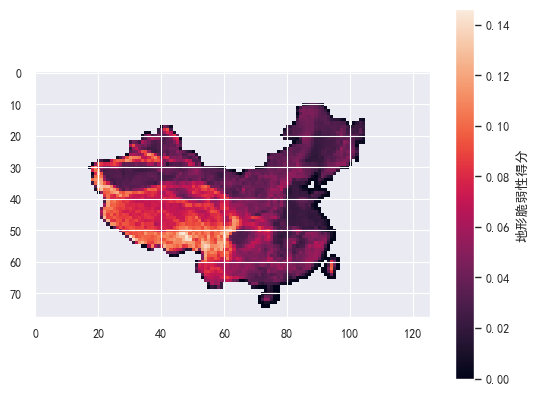

In [49]:
def l2_normalize_matrix(matrix):
    l2_norm = np.linalg.norm(matrix, ord=2)

    if l2_norm == 0:
        return matrix  
    normalized_matrix = matrix / l2_norm
    return normalized_matrix

matrix = df_gao.values  
df_gao = l2_normalize_matrix(matrix)
df_gao = pd.DataFrame(df_gao)
matrix = df_px.values  
df_px = l2_normalize_matrix(matrix)
df_px = pd.DataFrame(df_px)
matrix = df_pd.values  
df_pd = l2_normalize_matrix(matrix)
df_pd = pd.DataFrame(df_pd)
score1=df_gao+df_px+df_pd
score1=score1.replace(0,np.nan) 
plt.imshow(score1)
plt.colorbar(label='地形脆弱性得分')
plt.savefig('C:/Users/c/Desktop/地形脆弱度得分.jpg',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')

## 土地类型得分

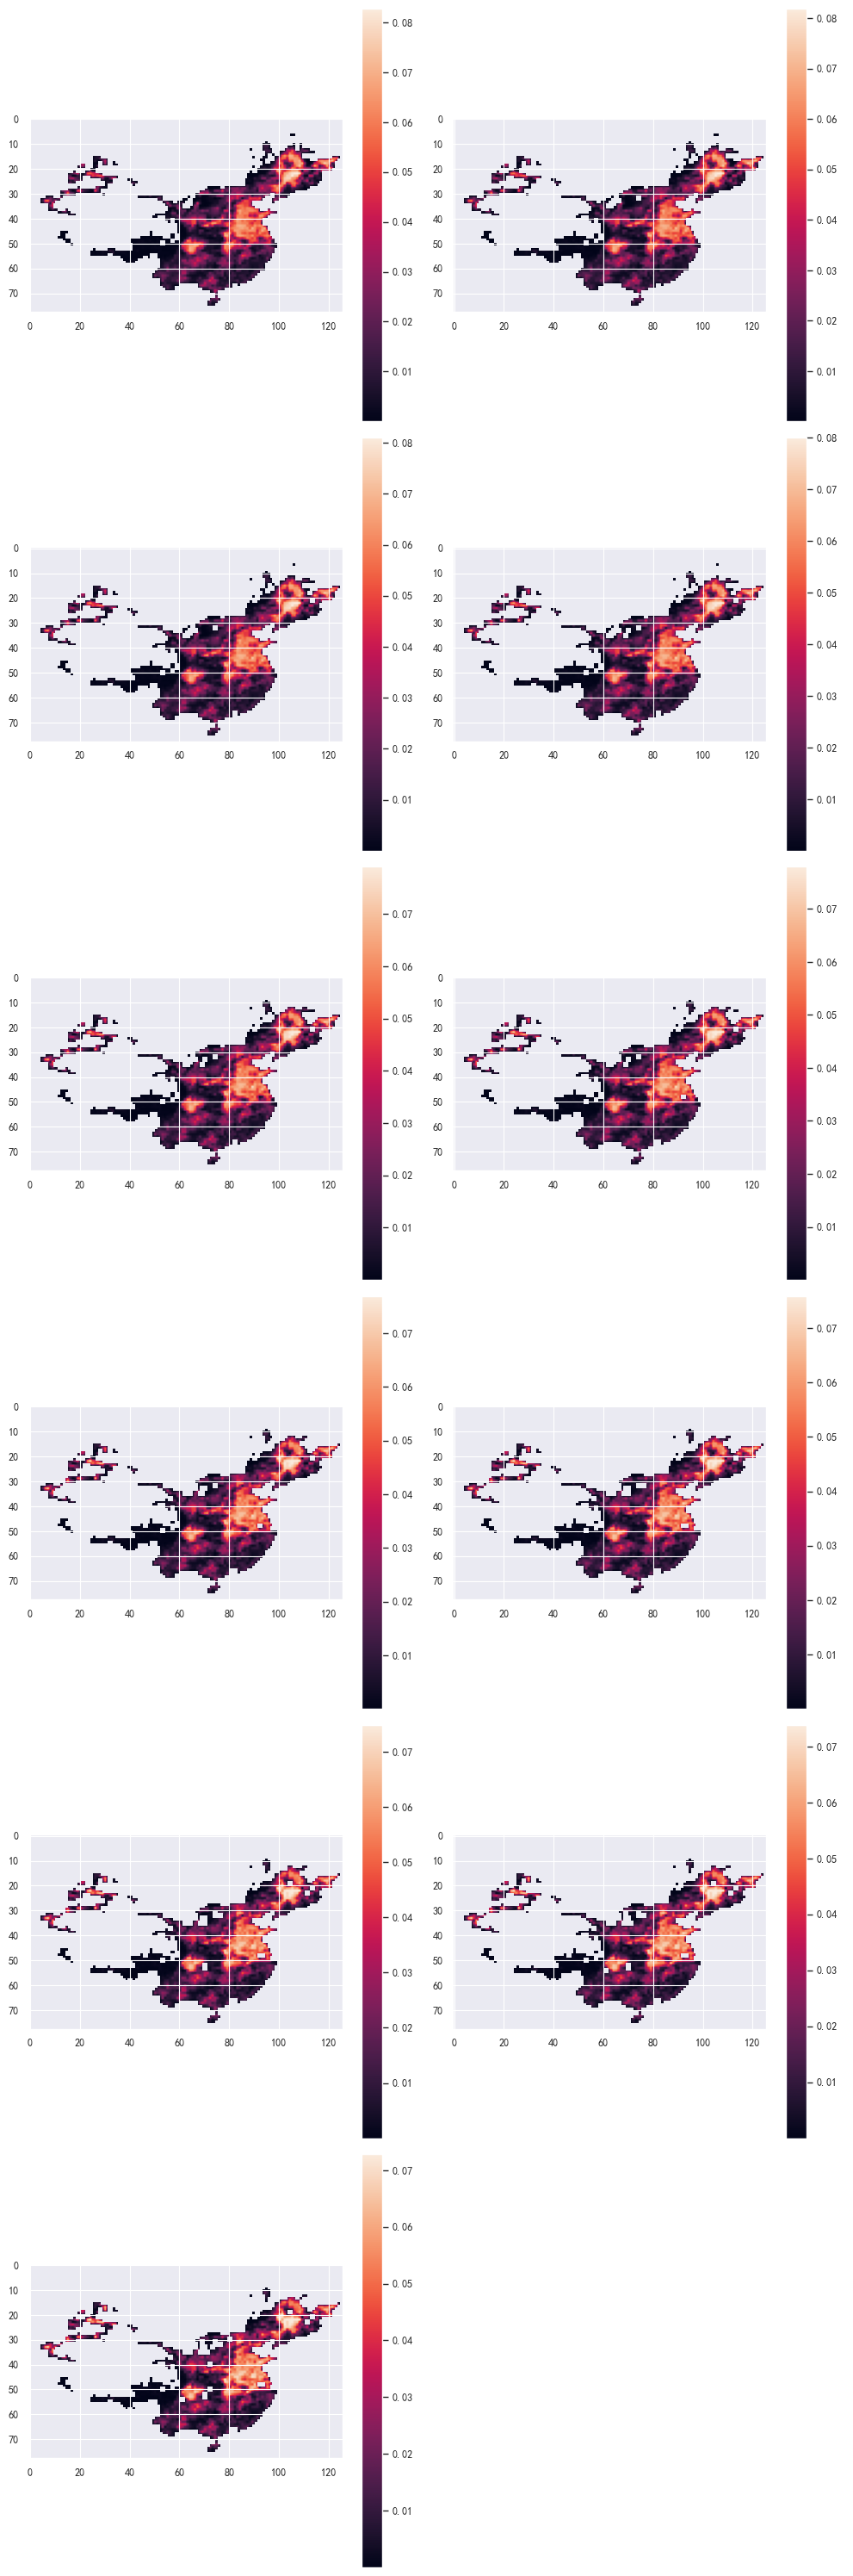

In [50]:
excel_file_path = 'crop_data1.xlsx' 
excel_data = pd.ExcelFile(excel_file_path)
sheet_names = excel_data.sheet_names 

fig,axes = plt.subplots(6,2,figsize=(10,30))
for idx, sheet_name in enumerate(sheet_names):

    matrix = excel_data.parse(sheet_name).values
    l2 = l2_normalize_matrix(matrix)
    l3 = pd.DataFrame(l2)
    l3=l3.replace(0,np.nan) 
    ax = axes[idx // 2, idx % 2]  
    cax = ax.imshow(l3)
    fig.colorbar(cax,ax=ax)

axes[-1,-1].axis('off')     
plt.tight_layout()
plt.savefig('C:/Users/c/Desktop/crop脆弱度得分.jpg',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

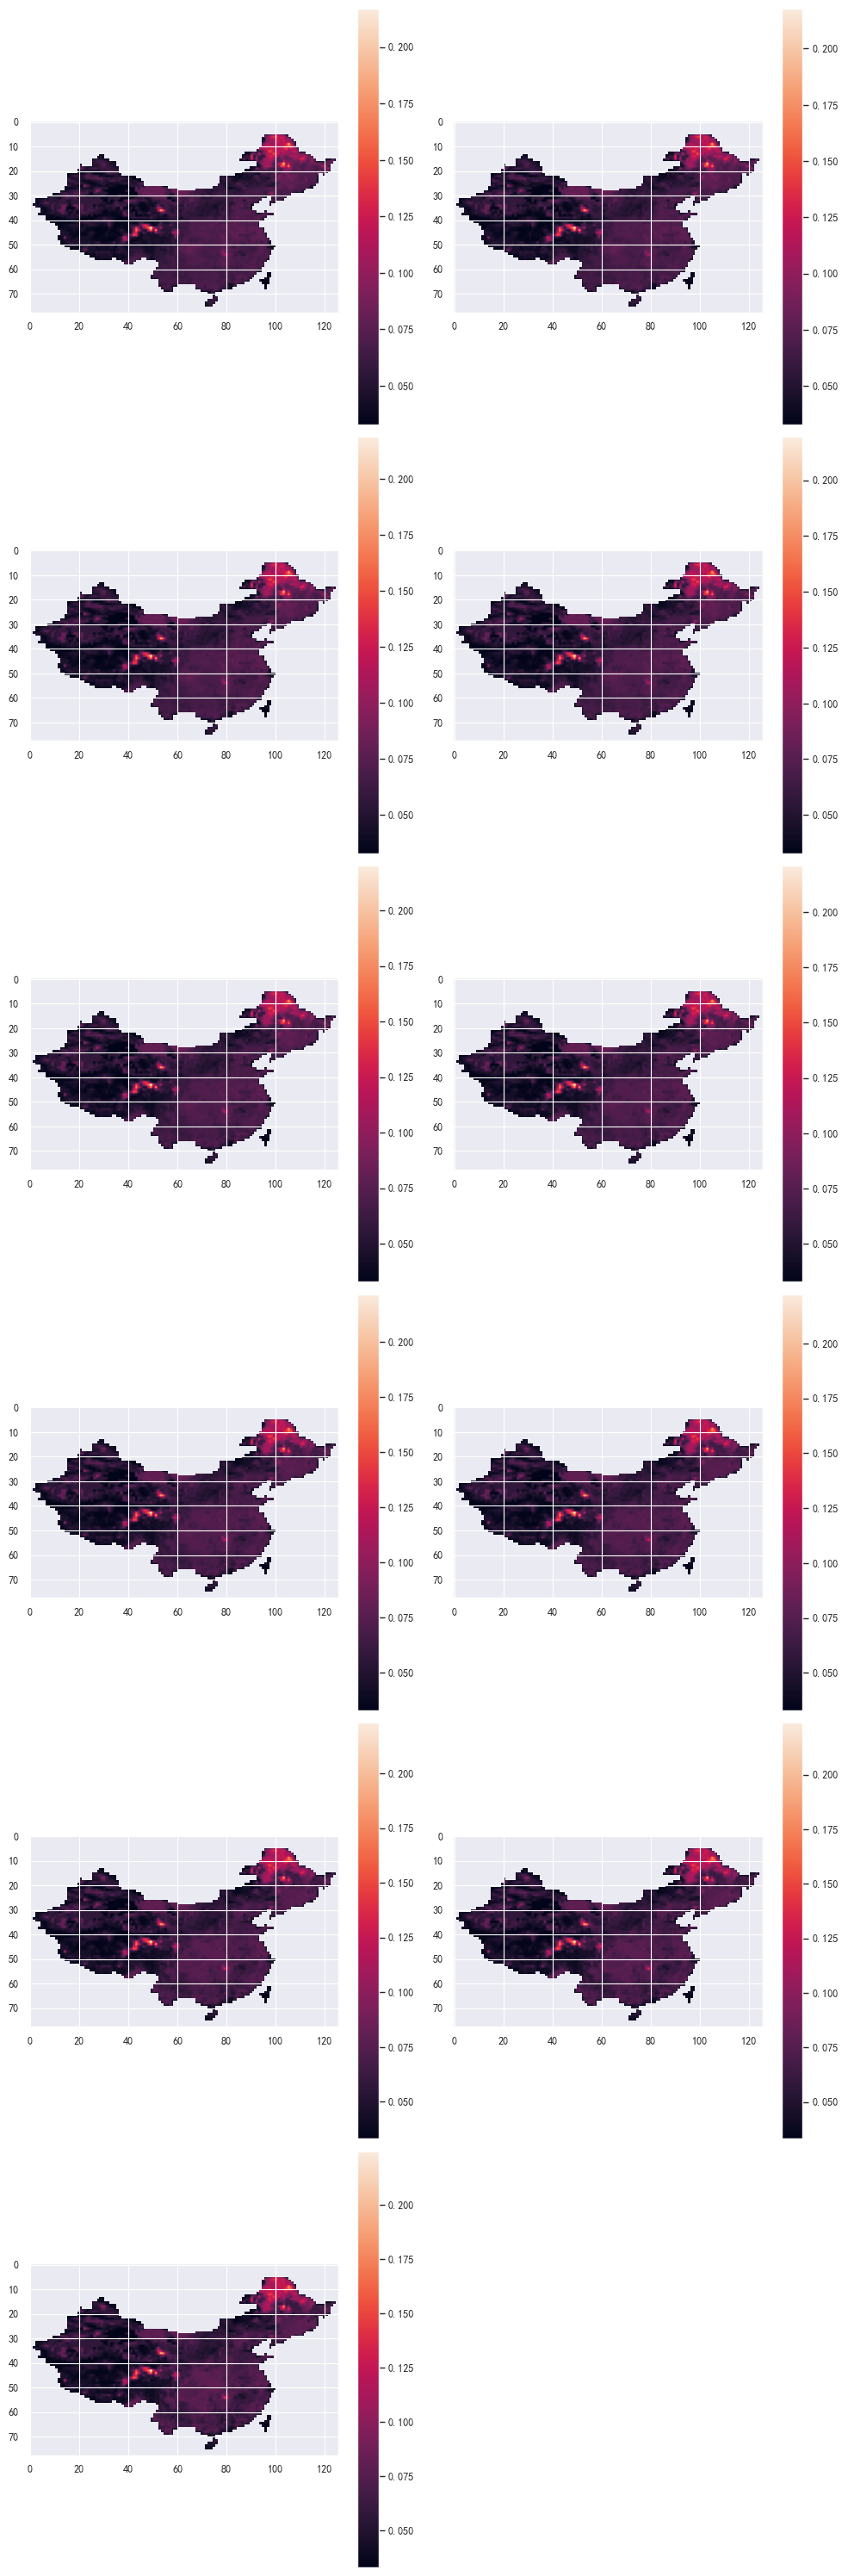

In [53]:
excel_file_paths = [
    'crop_data1.xlsx',
    'forest_data1.xlsx',
    'grass_data1.xlsx',
    'shrub_data1.xlsx',
    'wet_data1.xlsx'
]

all_excel_data = []
for file_path in excel_file_paths:
    excel_data = pd.ExcelFile(file_path)
    all_excel_data.append(excel_data)

sheet_names = all_excel_data[0].sheet_names 
fig,axes = plt.subplots(6,2,figsize=(10,30))

for idx, sheet_name in enumerate(sheet_names):
    combined_matrix = None
    for excel_data in all_excel_data:
        matrix = excel_data.parse(sheet_name).values  
        normalized_matrix = l2_normalize_matrix(matrix)  
        if combined_matrix is None:
            combined_matrix = normalized_matrix
        else:
            combined_matrix += normalized_matrix  
    combined_df = pd.DataFrame(combined_matrix)
    combined_df = combined_df.replace(0, np.nan)
    ax = axes[idx // 2, idx % 2] 
    cax = ax.imshow(combined_df)
    fig.colorbar(cax, ax=ax)

axes[-1,-1].axis('off')
plt.tight_layout()
plt.savefig('C:/Users/c/Desktop/土地类型脆弱度得分.jpg',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()

## 整体得分

In [47]:
def crop_to_divisible(matrix, target_shape):
    new_height = (matrix.shape[0] // target_shape[0]) * target_shape[0]
    new_width = (matrix.shape[1] // target_shape[1]) * target_shape[1]
    return matrix[:new_height, :new_width]

def downsample_matrix(matrix, target_shape):
    matrix_cropped = crop_to_divisible(matrix, target_shape)
    factor_x = matrix_cropped.shape[0] // target_shape[0]
    factor_y = matrix_cropped.shape[1] // target_shape[1]
    downsampled = matrix_cropped.reshape(target_shape[0], factor_x, target_shape[1], factor_y).mean(axis=(1, 3))
    return downsampled

small_matrix = crop.values  
excel_file_path = '降雨量预测.xlsx'  
excel_data = pd.ExcelFile(excel_file_path)

output_excel_path = '降雨量预测+.xlsx'
writer = pd.ExcelWriter(output_excel_path, engine='xlsxwriter')

for sheet_name in excel_data.sheet_names:
    large_matrix = excel_data.parse(sheet_name).values  
    downsampled_matrix = downsample_matrix(large_matrix, small_matrix.shape)
    downsampled_df = pd.DataFrame(downsampled_matrix)
    downsampled_df = downsampled_df.fillna(0)
    downsampled_df.to_excel(writer, sheet_name=sheet_name, index=False)

writer.save()

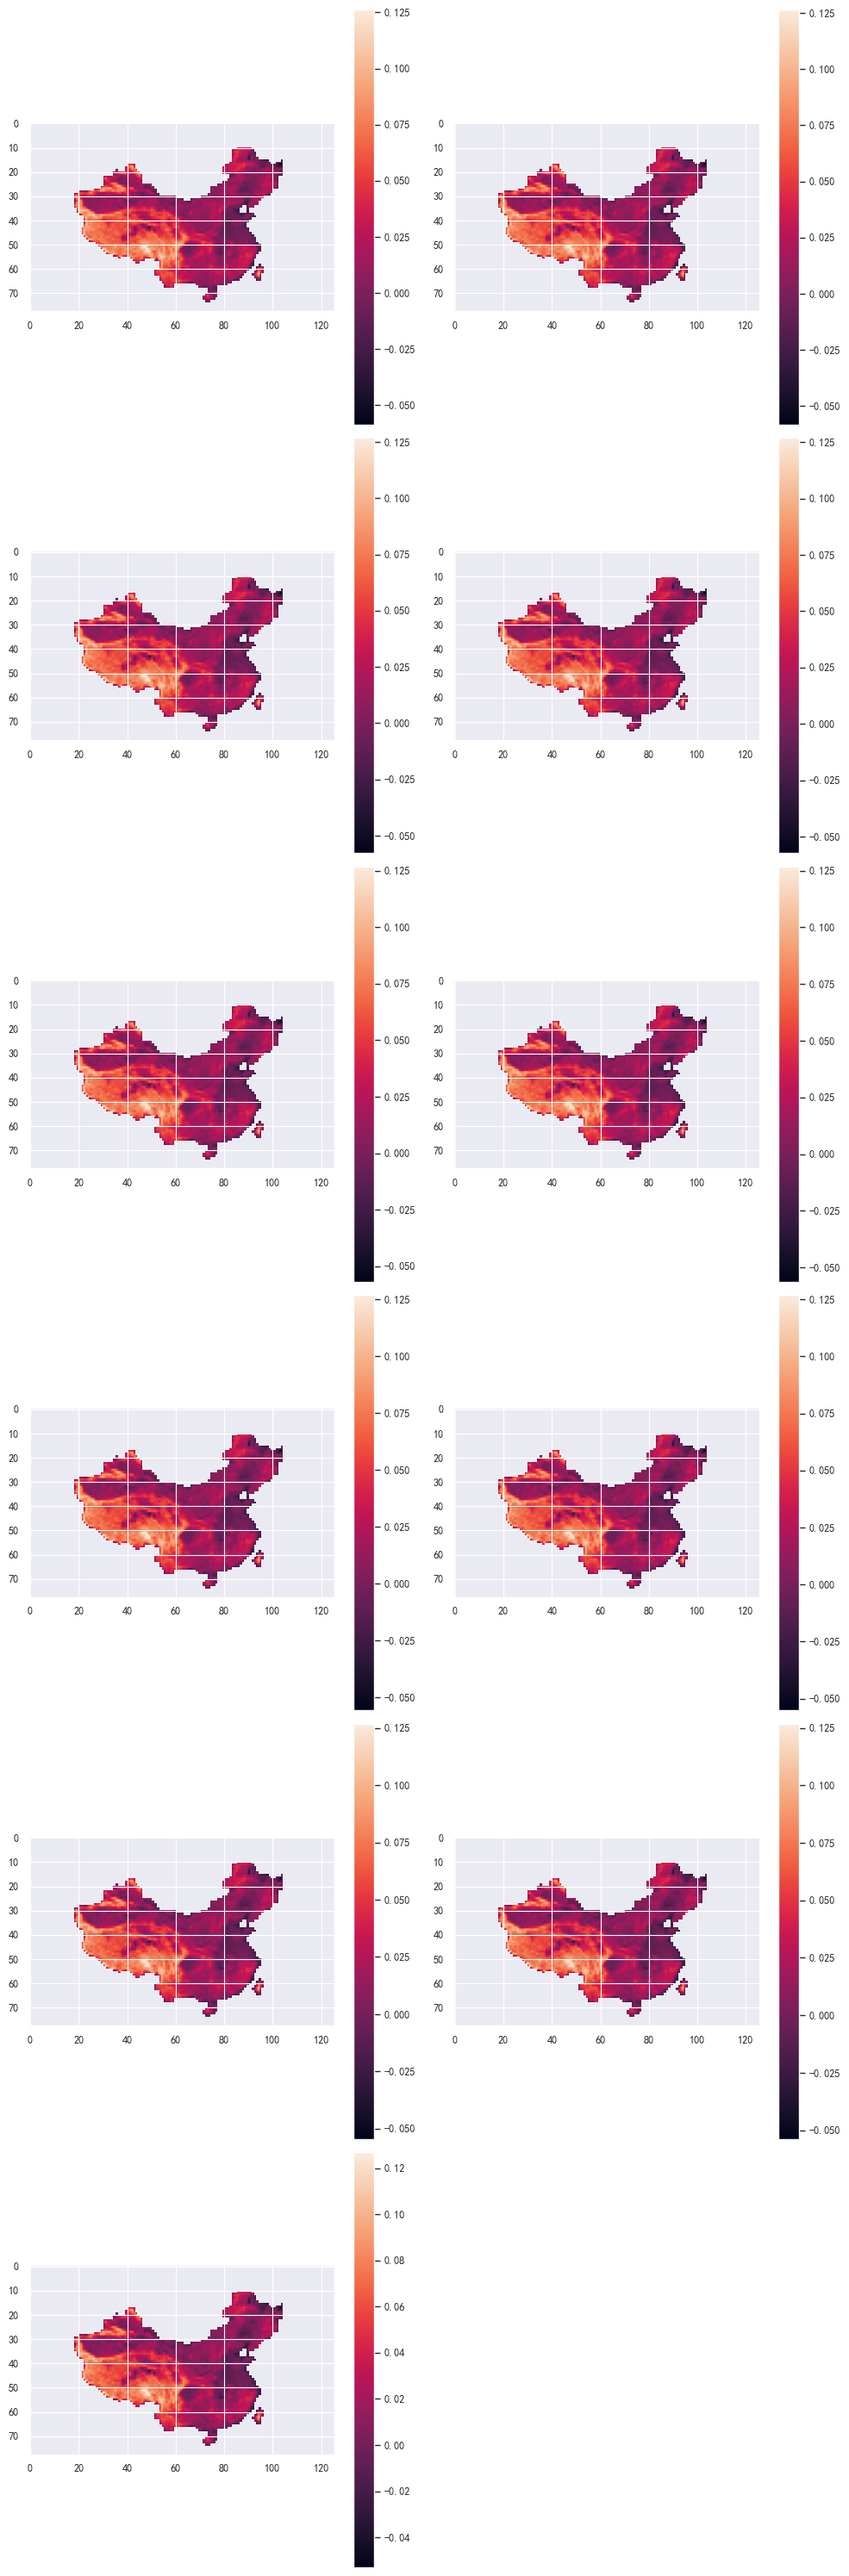

In [52]:
excel_file_paths = [
    'crop_data1.xlsx',
    'forest_data1.xlsx',
    'grass_data1.xlsx',
    'shrub_data1.xlsx',
    'wet_data1.xlsx',
    '降雨量预测+.xlsx',
]

all_excel_data = []
for file_path in excel_file_paths:
    excel_data = pd.ExcelFile(file_path)
    all_excel_data.append(excel_data)

sheet_names = all_excel_data[0].sheet_names 
fig,axes = plt.subplots(6,2,figsize=(10,30))

for idx, sheet_name in enumerate(sheet_names):
    combined_matrix = None
    for excel_data in all_excel_data:
        matrix = excel_data.parse(sheet_name).values  
        normalized_matrix = l2_normalize_matrix(matrix)  
        if combined_matrix is None:
            combined_matrix = normalized_matrix
        else:
            combined_matrix += normalized_matrix  
    
    subtract_matrix = all_excel_data[5].parse(sheet_name).values
    normalized_subtract_matrix = l2_normalize_matrix(subtract_matrix)  

    final_matrix = -0.5*combined_matrix+normalized_subtract_matrix+score1

    final_df = pd.DataFrame(final_matrix)
    final_df = final_df.replace(0, np.nan)
    ax = axes[idx // 2, idx % 2] 
    cax = ax.imshow(final_df)
    fig.colorbar(cax, ax=ax)
axes[-1,-1].axis('off')
plt.tight_layout()
plt.savefig('C:/Users/c/Desktop/整体脆弱度得分.jpg',
            dpi=400,
            bbox_inches = 'tight',
            facecolor = 'w',
            edgecolor = 'b')
plt.show()